In [7]:
from google.colab import drive
import os
drive.mount('/content/gdrive')
os.chdir('/content/gdrive/My Drive/EECS 442/colorization/')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
os.listdir('dataset/validation')

['Copy of chap44img13.jpg',
 'Copy of Copy of chap42img3.jpg',
 'Copy of Copy of chap44img13.jpg',
 'Copy of Copy of chap39img9.jpg']

In [9]:
import os
import cv2
import numpy as np
from tqdm import tqdm # Displays a progress bar
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, Subset, DataLoader, random_split
from model import *
import random


# constants
epochs = 50
x_shape = 512
y_shape = 512
fixed_seed_num = 1234
np.random.seed(fixed_seed_num)


device = "cuda" if torch.cuda.is_available() else "cpu" # Configure device
gen = Generator().to(device)
disc = Discriminator().to(device)

criterion_discriminator = nn.BCELoss() # Specify the loss layer
cgan_loss_weight = [5,100]
# TODO: Modify the line below, experiment with different optimizers and parameters (such as learning rate)
optimizer_disc = optim.Adam(disc.parameters(), lr=1e-4, betas=(0.9,0.999), eps=1e-08) # Specify optimizer and assign trainable parameters to it, weight_decay is L2 regularization strength
optimizer_cGAN = optim.Adam(gen.parameters(), lr=1e-3, betas=(0.9,0.999), eps=1e-08)


# constants
dataset = 'dataset/train/'
store2 = 'dataset/generated_images/'
val_data = 'dataset/validation/'
store = 'dataset/generated_Images/'


samples = len(os.listdir(dataset))
val_samples = len(os.listdir(val_data))
rgb = np.zeros((samples, x_shape, y_shape, 3))
gray = np.zeros((samples, x_shape, y_shape, 1))
rgb_val = np.zeros((val_samples, x_shape, y_shape, 3))
gray_val = np.zeros((val_samples, x_shape, y_shape, 1))

'''
for i, image in enumerate(os.listdir(dataset)[:samples]):
    I = cv2.imread(dataset+image)
    I = cv2.resize(I, (x_shape, y_shape))
#     J = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)
#     J = J.reshape(J.shape[0], J.shape[1], 1)
    rgb[i] = I;
#     gray[i] = J

for i, image in enumerate(os.listdir(val_data)[:val_samples]):
    I = cv2.imread(val_data+image)
    I = cv2.resize(I, (x_shape, y_shape))
    J = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)
    J = J.reshape(J.shape[0], J.shape[1], 1)
    rgb_val[i] = I; gray_val[i] = J
    


data_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])
manga_dataset = datasets.ImageFolder(root=dataset, transform=data_transform)
dataset_loader = torch.utils.data.DataLoader(manga_dataset,
                                             batch_size=4, shuffle=True,
                                             num_workers=4)

for data in dataset_loader:
    print(data.size())
'''

# trains cGAN model
def train(gen, disc, disc_trainloader,cGAN_trainloader, valloader):
    
    print("Start training...")
    
    samples = len(rgb)


    #gray = gray.to(device)
    #optimizer.zero_grad()
    
    criterion = nn.BCELoss()
    def cos(y_pred, y_true):
        return torch.sum(y_pred*y_true)/torch.norm(y_pred)/torch.norm(y_true)
    mae = nn.L1Loss()
    mse = nn.MSELoss()
    # todo: split into 4 battches
    #disc.fit([inputs, outputs], y, batch_size=4)
    batch_size = 4
    num_epoch = 1
    disc.train()
    gen.eval()
    for i in range(num_epoch):
        running_loss = []
        for grays, true_rgbs in tqdm(disc_trainloader):
            print(grays.shape)
            grays = grays.to(device)
            true_rgbs = true_rgbs.to(device)
            grays = grays.permute((0,3,1,2))
            true_rgbs = true_rgbs.permute((0,3,1,2))
            generated_rgbs = gen(grays.float())
            optimizer_disc.zero_grad() # Clear gradients from the previous iteration
            pred1 = disc(grays.float(), true_rgbs.float())
            pred2 = disc(grays.float(), generated_rgbs.float())
            label1 = torch.ones([grays.size()[0], 1], dtype=torch.float, device=device)
            label2 = torch.zeros([grays.size()[0], 1], dtype=torch.float, device=device)
            loss1 = criterion(pred1, label1) # Calculate the loss
            loss2 = criterion(pred2, label2)
            loss = loss1 + loss2
            running_loss.append(loss.item())
            loss.backward() # Backprop gradients to all tensors in the network
            optimizer_disc.step() # Update trainable weights
        print("Epoch {} loss:{}".format(i+1,np.mean(running_loss))) # Print the average loss for this epoch


    # # cGAN.fit(gray, [np.ones((samples, 1)), rgb], epochs=1, batch_size=batch, callbacks=[tensorboard],validation_data=[gray_val,[np.ones((val_samples,1)),rgb_val]])
    # cGAN.fit(gray, [np.ones((samples, 1)), rgb], batch_size=batch,
    #          validation_data=[gray_val, [np.ones((val_samples, 1)), rgb_val]])
    # todo: split into  cGAN_trainloader battches
    num_epoch = 1
    disc.eval()
    gen.train()
    for i in range(num_epoch):
        running_loss = []
        for batch, label in tqdm(cGAN_trainloader):
            batch = batch.to(device).float()
            label = label.to(device).float()
            #plt.figure()
            #plt.imshow(label[0].cpu().numpy().astype(int))
            batch = batch.permute((0,3,1,2))
            label = label.permute((0,3,1,2))
            optimizer_cGAN.zero_grad() # Clear gradients from the previous iteration
            gen_image = gen(batch).float()
            #plt.figure()
            #plt.imshow(gen_image[0].permute(1,2,0).detach().cpu().numpy().astype(int))
            y = disc(batch, gen_image)
            y_truth = torch.ones([batch.size()[0], 1], dtype=torch.float, device=device)
            loss =  5*criterion(y, y_truth) # Calculate the loss
            loss += 100*(mse(gen_image, label)+(1+cos(gen_image,label))*mae(gen_image, label))
            running_loss.append(loss.item())
            loss.backward() # Backprop gradients to all tensors in the network
            optimizer_cGAN.step() # Update trainable weights
        print("Epoch {} loss:{}".format(i+1,np.mean(running_loss))) # Print the average loss for this epoch
        #train_loss_history.append(np.mean(running_loss))
        '''
        #print("Evaluate on validation set...")
        #correct = 0
        running_loss_val = []
        #TODO SPLIT INTO VALLOADER BATCHES
        disc.eval()
        gen.eval()
        for batchval, labelval in tqdm(valloader):
            batchval = batchval.to(device)
            labelval = labelval.to(device)
            batchval = batchval.permute((0,3,1,2))
            labelval = labelval.permute((0,3,1,2))
            gen_image_val = gen(batchval.float())
            y_val1 = disc(batchval.float(), gen_image_val.float())
            y_val2 = disc(batchval.float(), labelval.float())
            y_val_truth1 = torch.zeros([batch_size, 1], dtype=torch.float, device=device)
            y_val_truth2 = torch.ones([batch_size, 1], dtype=torch.float, device=device)
            loss_val = cgan_loss_weight[0] * (criterion(y_val1, y_val_truth1)) # Calculate the loss
            loss_val += cgan_loss_weight[0] * (criterion(y_val2, y_val_truth2))
            loss_val += cgan_loss_weight[1] * custom_loss_2(labelval.float(), gen_image_val.float())
            running_loss_val.append(loss_val.item())
            

            #correct += (torch.argmax(predval, dim=1) == labelval).sum().item()
        #val_loss_history.append(np.mean(running_loss_val))
        #acc = correct / (len(valloader.dataset))
        #print("Evaluation accuracy: {}".format(acc))
        '''

# get train dataset
y_train = np.zeros((samples, 1))
for i, image in enumerate(os.listdir(dataset)[:samples]):
    I = cv2.imread(dataset + image)
    I = cv2.resize(I, (x_shape, y_shape))
    J = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)
    J = J.reshape(J.shape[0], J.shape[1], 1)
    rgb[i] = I;
    gray[i] = J

# get validation dataset
for i, image in enumerate(os.listdir(val_data)[:val_samples]):
    I = cv2.imread(val_data + image)
    I = cv2.resize(I, (x_shape, y_shape))
    J = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)
    J = J.reshape(J.shape[0], J.shape[1], 1)
    rgb_val[i] = I;
    gray_val[i] = J

#todo
# initialise data generator
'''
datagen = ImageDataGenerator(zoom_range=0.2, fill_mode='wrap', horizontal_flip=True,
                             vertical_flip=True, rotation_range=15)
datagen.fit(rgb)
'''

        
class MangaDataset(Dataset):
    def __init__(self, rgb, gray, transform=None):
        self.rgb = rgb
        self.gray = gray
        self.transform = transform
    
    def __len__(self):
        return len(self.rgb)
    
    def __getitem__(self,idx):
        image_left = self.gray[idx]
        image_right = self.rgb[idx]
        # Random horizontal flipping
        if random.random() > 0.5:
            image_left = np.flip(image_left,1)
            image_right = np.flip(image_right,1)
        # Random vertical flipping
        if random.random() > 0.5:
            image_left = np.flip(image_left,2)
            image_right = np.flip(image_right,2)
        return (torch.tensor(self.gray[idx]), torch.tensor(self.rgb[idx]))

disc_trainloader = DataLoader(MangaDataset(rgb, gray), batch_size=4)
cGAN_trainloader = DataLoader(MangaDataset(rgb, gray), batch_size=4)
valloader = DataLoader(MangaDataset(rgb, gray), batch_size=4)

        
epochs = 200
b=1

try:
  gen.load_state_dict(torch.load('gen.pt'))
except Exception as e:
  print(e)
try:
  disc.load_state_dict(torch.load('disc.pt'))
except Exception as e:
  print(e)

for e in range(epochs):
    print('Epoch', e)
    train(gen,disc,disc_trainloader,cGAN_trainloader, valloader)
    gray_val_tensor = torch.tensor(gray_val)
    gray_val_tensor = gray_val_tensor.permute((0,3,1,2))
    gray_val_tensor.to(device)
    gen.eval()
    gen_image_val = gen(gray_val_tensor.float().to(device))
    gen_image_val = gen_image_val.permute((0,2,3,1))
    if e%1 == 0: 
        for j in range(val_samples):
            if not os.path.exists(store2):
                os.mkdir(store2)
            output = gen_image_val[j].detach().cpu().numpy()
            output = (output-np.min(output))/(np.max(output)-np.min(output))*255
            cv2.imwrite(store2+str(e)+str(j)+'.jpg', output)
    if e%5 == 0:
        torch.save(gen.state_dict(), 'gen.pt')
        torch.save(disc.state_dict(), 'disc.pt')







  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 0
Start training...
torch.Size([4, 512, 512, 1])





  3%|▎         | 1/30 [00:00<00:26,  1.11it/s]

torch.Size([4, 512, 512, 1])





  7%|▋         | 2/30 [00:03<00:36,  1.29s/it]

torch.Size([4, 512, 512, 1])





 10%|█         | 3/30 [00:05<00:42,  1.57s/it]

torch.Size([4, 512, 512, 1])





 13%|█▎        | 4/30 [00:07<00:45,  1.76s/it]

torch.Size([4, 512, 512, 1])





 17%|█▋        | 5/30 [00:09<00:47,  1.89s/it]

torch.Size([4, 512, 512, 1])





 20%|██        | 6/30 [00:11<00:47,  1.98s/it]

torch.Size([4, 512, 512, 1])





 23%|██▎       | 7/30 [00:14<00:46,  2.04s/it]

torch.Size([4, 512, 512, 1])





 27%|██▋       | 8/30 [00:16<00:46,  2.09s/it]

torch.Size([4, 512, 512, 1])





 30%|███       | 9/30 [00:18<00:44,  2.13s/it]

torch.Size([4, 512, 512, 1])





 33%|███▎      | 10/30 [00:20<00:42,  2.15s/it]

torch.Size([4, 512, 512, 1])





 37%|███▋      | 11/30 [00:22<00:41,  2.16s/it]

torch.Size([4, 512, 512, 1])





 40%|████      | 12/30 [00:25<00:39,  2.17s/it]

torch.Size([4, 512, 512, 1])





 43%|████▎     | 13/30 [00:27<00:36,  2.17s/it]

torch.Size([4, 512, 512, 1])





 47%|████▋     | 14/30 [00:29<00:34,  2.18s/it]

torch.Size([4, 512, 512, 1])





 50%|█████     | 15/30 [00:31<00:32,  2.18s/it]

torch.Size([4, 512, 512, 1])





 53%|█████▎    | 16/30 [00:33<00:30,  2.18s/it]

torch.Size([4, 512, 512, 1])





 57%|█████▋    | 17/30 [00:35<00:28,  2.18s/it]

torch.Size([4, 512, 512, 1])





 60%|██████    | 18/30 [00:38<00:26,  2.18s/it]

torch.Size([4, 512, 512, 1])





 63%|██████▎   | 19/30 [00:40<00:24,  2.19s/it]

torch.Size([4, 512, 512, 1])





 67%|██████▋   | 20/30 [00:42<00:21,  2.19s/it]

torch.Size([4, 512, 512, 1])





 70%|███████   | 21/30 [00:44<00:19,  2.19s/it]

torch.Size([4, 512, 512, 1])





 73%|███████▎  | 22/30 [00:46<00:17,  2.19s/it]

torch.Size([4, 512, 512, 1])





 77%|███████▋  | 23/30 [00:49<00:15,  2.18s/it]

torch.Size([4, 512, 512, 1])





 80%|████████  | 24/30 [00:51<00:13,  2.19s/it]

torch.Size([4, 512, 512, 1])





 83%|████████▎ | 25/30 [00:53<00:10,  2.19s/it]

torch.Size([4, 512, 512, 1])





 87%|████████▋ | 26/30 [00:55<00:08,  2.19s/it]

torch.Size([4, 512, 512, 1])





 90%|█████████ | 27/30 [00:57<00:06,  2.18s/it]

torch.Size([4, 512, 512, 1])





 93%|█████████▎| 28/30 [01:00<00:04,  2.19s/it]

torch.Size([4, 512, 512, 1])





 97%|█████████▋| 29/30 [01:02<00:02,  2.19s/it]

torch.Size([2, 512, 512, 1])





100%|██████████| 30/30 [01:04<00:00,  2.08s/it]





  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1 loss:0.3792178751900792





  3%|▎         | 1/30 [00:01<00:45,  1.57s/it]


  7%|▋         | 2/30 [00:02<00:41,  1.49s/it]


 10%|█         | 3/30 [00:04<00:40,  1.51s/it]


 13%|█▎        | 4/30 [00:06<00:39,  1.53s/it]


 17%|█▋        | 5/30 [00:07<00:38,  1.54s/it]


 20%|██        | 6/30 [00:09<00:37,  1.55s/it]


 23%|██▎       | 7/30 [00:10<00:35,  1.55s/it]


 27%|██▋       | 8/30 [00:12<00:34,  1.56s/it]


 30%|███       | 9/30 [00:13<00:32,  1.56s/it]


 33%|███▎      | 10/30 [00:15<00:31,  1.57s/it]


 37%|███▋      | 11/30 [00:16<00:29,  1.57s/it]


 40%|████      | 12/30 [00:18<00:28,  1.57s/it]


 43%|████▎     | 13/30 [00:20<00:26,  1.57s/it]


 47%|████▋     | 14/30 [00:21<00:25,  1.57s/it]


 50%|█████     | 15/30 [00:23<00:23,  1.57s/it]


 53%|█████▎    | 16/30 [00:24<00:21,  1.57s/it]


 57%|█████▋    | 17/30 [00:26<00:20,  1.56s/it]


 60%|██████    | 18/30 [00:27<00:18,  1.56s/it]


 63%|██████▎   | 19/30 [00:29<00:17,  1.57s/it]


 67%|██████▋   | 20/30 [00:31<00:15,  1.57s/it]


 70%|█

Epoch 1 loss:37954.124739583334





  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1
Start training...
torch.Size([4, 512, 512, 1])





  3%|▎         | 1/30 [00:00<00:24,  1.20it/s]

torch.Size([4, 512, 512, 1])





  7%|▋         | 2/30 [00:03<00:34,  1.24s/it]

torch.Size([4, 512, 512, 1])





 10%|█         | 3/30 [00:05<00:41,  1.52s/it]

torch.Size([4, 512, 512, 1])





 13%|█▎        | 4/30 [00:07<00:44,  1.72s/it]

torch.Size([4, 512, 512, 1])





 17%|█▋        | 5/30 [00:09<00:46,  1.86s/it]

torch.Size([4, 512, 512, 1])





 20%|██        | 6/30 [00:11<00:47,  1.96s/it]

torch.Size([4, 512, 512, 1])





 23%|██▎       | 7/30 [00:13<00:46,  2.02s/it]

torch.Size([4, 512, 512, 1])





 27%|██▋       | 8/30 [00:16<00:45,  2.07s/it]

torch.Size([4, 512, 512, 1])





 30%|███       | 9/30 [00:18<00:44,  2.11s/it]

torch.Size([4, 512, 512, 1])





 33%|███▎      | 10/30 [00:20<00:42,  2.14s/it]

torch.Size([4, 512, 512, 1])





 37%|███▋      | 11/30 [00:22<00:40,  2.15s/it]

torch.Size([4, 512, 512, 1])





 40%|████      | 12/30 [00:24<00:38,  2.16s/it]

torch.Size([4, 512, 512, 1])





 43%|████▎     | 13/30 [00:27<00:36,  2.17s/it]

torch.Size([4, 512, 512, 1])


KeyboardInterrupt: ignored

In [0]:
gen = Generator()
gen.load_state_dict(torch.load('gen.pt'))
I = cv2.imread(dataset + image)
I = cv2.resize(I, (x_shape, y_shape))
J = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)
J = J.reshape(J.shape[0], J.shape[1], 1)
rgb = I;
gray = J

In [0]:
epochs = 1
b=1
gen = Generator().to(device)
for e in range(epochs):
    print('Epoch', e)
    #train(gen,disc,disc_trainloader,cGAN_trainloader, valloader)
    #torch.save(gen.state_dict(), 'gen.pt')
    gen.load_state_dict(torch.load('gen.pt'))
    gray_val_tensor = torch.tensor(gray_val)
    gray_val_tensor = gray_val_tensor.permute((0,3,1,2))
    gen.eval()
    gen_image_val = gen(gray_val_tensor.float())
    gen_image_val = gen_image_val.permute((0,2,3,1))
    if e%1 == 0: 
        for j in range(val_samples):
            if not os.path.exists(store2):
                os.mkdir(store2)
            print(gen_image_val.size())
            cv2.imwrite(store2+str(e)+'.jpg', gen_image_val[j].detach().numpy())

Epoch 0


RuntimeError: ignored

[[[ 27   8  40]
  [ 48  32  59]
  [ 61  46  67]
  ...
  [ 72  59  66]
  [ 56  43  50]
  [ 34  23  27]]

 [[ 50  34  63]
  [ 88  72  99]
  [117 104 124]
  ...
  [142 133 138]
  [111 102 105]
  [ 71  62  65]]

 [[ 65  49  78]
  [124 110 135]
  [178 165 183]
  ...
  [207 203 204]
  [161 157 156]
  [ 93  89  88]]

 ...

 [[ 80  66  89]
  [156 145 162]
  [217 209 220]
  ...
  [225 226 221]
  [174 175 169]
  [104 105  99]]

 [[ 64  51  71]
  [122 111 127]
  [173 163 172]
  ...
  [178 177 173]
  [139 140 134]
  [ 84  85  79]]

 [[ 37  24  42]
  [ 72  61  75]
  [ 99  89  97]
  ...
  [109 108 104]
  [ 88  89  83]
  [ 50  51  45]]]


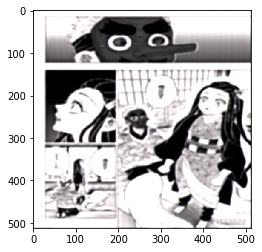

In [0]:
import matplotlib.pyplot as plt
img = plt.imread('dataset/generated_images/131.jpg')
print(img)
plt.imshow(img)

In [0]:
a = torch.tensor(np.array([[1,2,3],[1,2,3]]))
b = torch.tensor(np.array([[4,5,6],[4,5,6]]))
print(torch.sum(a))
print(torch.dot(a.view(-1), b.view(-1)))
print(4+10+18+4+10+18)
print(torch.norm(a.float()))

tensor(12)
tensor(64)
64
tensor(5.2915)
